# Assignment 2: recommender System

## Code from the lecture

In [21]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [22]:
#generate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [23]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN
def EucledianDist(a,b):
    return np.linalg.norm(a-b) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [24]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_cos=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_cos[i,j]=CosineDist(R[:,i],R[:,j])
            
D_euc=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_euc[i,j]=EucledianDist(R[:,i],R[:,j])            
                       

Wall time: 3min 43s


In [17]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [25]:
# With cosinus distance
CII("Star",D_cos)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [26]:
# With eucledian distance
CII("Star",D_euc)

recommending movies for: 'Star Wars (1977)'


989              Anna Karenina (1997)
1061    Four Days in September (1997)
1126          Truman Show, The (1998)
937        Smile Like Yours, A (1997)
1242               Night Flier (1997)
Name: title, dtype: object

In [27]:
test_res_cos=test_Score(D_cos,R)
test_res_euc=test_Score(D_euc,R)

Text(0.5, 1.0, 'With eucledian distance')

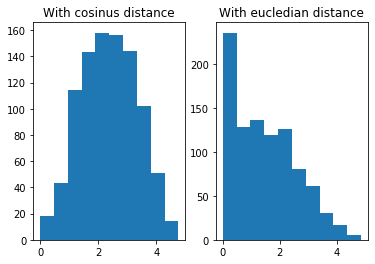

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(test_res_cos)
ax1.set_title('With cosinus distance')
ax2.hist(test_res_euc)
ax2.set_title('With eucledian distance')

In [30]:
print('mean value test results with cosinus:  ', np.mean(test_res_cos))
print('mean value test results with eucledian:', np.mean(test_res_euc))

mean value test results with cosinus:   2.3701802757158004
mean value test results with eucledian: 1.4630328738069989


## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [36]:
M_random = np.random.randint(943, size=(5))
print(M_random)

[784 441   9  64 936]


## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$
